In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
# from tqdm import

In [2]:
connectivity_min, connectivity_max = 0.1,65
random_input_span = (9.5,13.5)
# random_input_span = (1.2,2.8)

total_time = 100
delay = 0.1
alpha = 20

current_models = ['IF','Rotational','Non_repulsive_rotational']
neuron_model = current_models[2]

model_folder_name = neuron_model+'_ensembles'
version = '_cluster_computed'

# Capture related ensembles

In [3]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [4]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1])
target_networks_name = target_networks_name + version
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

delay_folder_name = 'd_{}'.format(delay)
alpha_folder_name = 'alpha_{}'.format(alpha)

In [5]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
mean_periods_arr_dict = {}

In [6]:
for g_folder in desired_g_folders:
    g_d_path = os.path.join(target_path, g_folder, delay_folder_name, alpha_folder_name)
    
    try:
        g_ensembles_list = list_folders_in_path(g_d_path)
        g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
    
        sigma_glossary_dict[g] = []
        mean_periods_arr_dict[g] = []
        amin_saman_param_glossary_dict[g] = []
        
    except: #if the given connectivity and delay has not been measured even once
        continue
    
    for ensemble_num in g_ensembles_list:
        ensemble_path = os.path.join(g_d_path, ensemble_num)
        with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
            sigma = float( file.readline() )
            sigma_glossary_dict[g].append( sigma )
        
#         if neuron_model == 'Rotational' or neuron_model == 'Non_repulsive_rotational' : #if not does not exist
        if neuron_model == 'Rotational': #if not does not exist
            with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                amin_saman_param = float( file.readline() )        
                amin_saman_param_glossary_dict[g].append( amin_saman_param )        
        
        mean_periods_arr_dict[g].append( np.loadtxt(os.path.join(ensemble_path,'mean_spiking_periods.txt')) )
        


## Standard deviation of the current

In [7]:
g_list = list(sigma_glossary_dict.keys())
g_list.sort()
sigma_mean = [ np.mean(sigma_glossary_dict[g]) for g in g_list ]
sigma_err = [ np.var(sigma_glossary_dict[g])**(0.5) for g in g_list ]

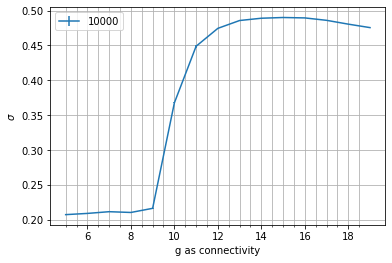

In [8]:
fig = plt.figure()
ax = fig.subplots()
ax.errorbar(x = g_list, y = sigma_mean, yerr = sigma_err, label = str(num_neurons))

plt.legend()
# ax.set_title('$\sigma$')
ax.set_xlabel('g as connectivity')
ax.set_ylabel('$\sigma$')

ax.set_xticks( np.arange(g_list[0], g_list[-1], 0.5 ), minor = True)

ax.grid(which='both')

fig.savefig(os.path.join(target_path,'sigma_g_{}_{}.png'.format(connectivity_min, connectivity_max)) )

## Amin Saman parameter

In [9]:
amin_saman_param_mean = [ np.mean(amin_saman_param_glossary_dict[g]) for g in g_list ]
amin_saman_param_err = [ np.var(amin_saman_param_glossary_dict[g])**(0.5) for g in g_list ]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
if neuron_model == 'Rotational': #if not does not exist
    fig = plt.figure()
    ax = fig.subplots()
    ax.errorbar(x = g_list, y = amin_saman_param_mean, yerr = amin_saman_param_err, label = str(num_neurons))

    plt.legend()
    # ax.set_title('$\sigma$')
    ax.set_xlabel('g as connectivity')
    ax.set_ylabel('$s$')
    fig.savefig(os.path.join(target_path,'amin_saman_param_g_{}_{}.png'.format(connectivity_min, connectivity_max) ) )

## Mean spikies period

In [11]:
def mean_heights_hist(pops_list,given_bins):
    heights_reservoir = np.zeros((len(pops_list),len(given_bins)-1))
    for i,pop in enumerate(pops_list):
        heights = np.histogram(pop, bins = given_bins, density = True)[0]
        heights_reservoir[i] = heights
    return np.mean(heights_reservoir,axis = 0)

In [12]:
# bins = np.arange(0,100,0.5)
bins = np.logspace(np.log10(0.1),np.log10(1000.0), 100)
mean_heights_dict = {}
for g in g_list:
    mean_heights_dict[g] = mean_heights_hist(mean_periods_arr_dict[g],bins)

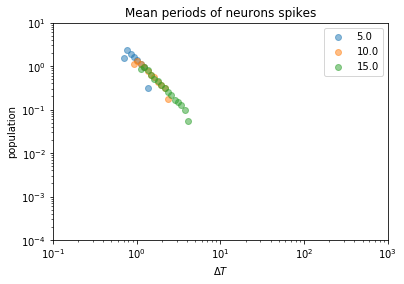

In [13]:
fig = plt.figure()
ax = fig.subplots()

ax.set_xscale("log")
ax.set_yscale("log")


desired_g_list = g_list[::5]

for g in desired_g_list:
    non_zero_mask = (mean_heights_dict[g] != 0 ) & (bins[:-1] != 0)
    ax.scatter(bins[:-1][non_zero_mask],mean_heights_dict[g][non_zero_mask],label = round(g,2), alpha = 0.5)
plt.legend()
plt.xlim(0.1, bins[-1])
# plt.ylim(10**-4, num_neurons)
# plt.ylim(10**-4, 10**2)
plt.ylim(num_neurons**-1, 10)
# plt.xscale('log')
# plt.yscale('log')


ax.set_title('Mean periods of neurons spikes')
ax.set_ylabel('population')
ax.set_xlabel('$\Delta T$')
fig.savefig(os.path.join(target_path,'mean_spiking_persiods_g_{}_{}.png'.format(connectivity_min,connectivity_max)) )

## Trending line in histogram

In [14]:
desired_g = 15

In [15]:
non_zero_mask = (mean_heights_dict[desired_g] != 0 ) & (bins[:-1] != 0)
x = bins[:-1][non_zero_mask]
y = mean_heights_dict[desired_g][non_zero_mask]

x_log = np.log10(x)
y_log = np.log10(y)

trend_curve = x**(np.polyfit(x_log,y_log,1)[0]) * 10**(np.polyfit(x_log,y_log,1)[1])
slope, shift = np.polyfit(x_log,y_log,1)

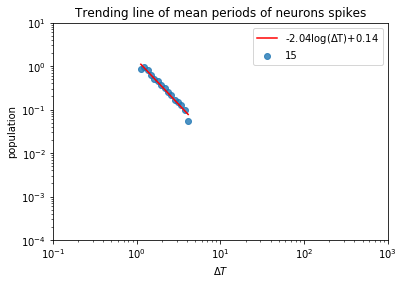

In [16]:
fig = plt.figure()
ax = fig.subplots()

ax.set_xscale("log")
ax.set_yscale("log")

ax.scatter(x,y,label = round(desired_g,2), alpha = 0.8)

ax.set_xlim(0.1, bins[-1])
ax.set_ylim(num_neurons**-1,10) #we are working with densities

ax.plot(x, trend_curve,'r-',label = '{:.2f}log($\Delta$T)+{:.2f}'.format(slope,shift))

plt.legend()
ax.set_title('Trending line of mean periods of neurons spikes')
ax.set_ylabel('population')
ax.set_xlabel('$\Delta T$')
fig.savefig(os.path.join(target_path,'mean_spiking_persiods_with_trending_line_g_{}_{}.png'.format(connectivity_min,connectivity_max)) )

# Silent neurons

In [17]:
def silent_neurons_num(pops_list):
    silent_num = np.zeros(len(pops_list))
    for i,pop in enumerate(pops_list):
        nan_num = np.count_nonzero(np.isnan(pop))
#         nan_num = 0 if nan_num != 0 else nan_num
        silent_num[i] = nan_num
    return np.mean(silent_num)

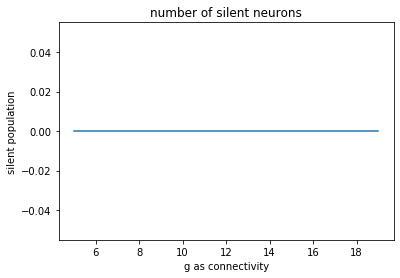

In [18]:
fig = plt.figure()
ax = fig.subplots()

silent_neurons = []

for g in g_list:
    silent_neurons.append( silent_neurons_num(mean_periods_arr_dict[g]) )

ax.plot(g_list,silent_neurons)
# plt.legend()

ax.set_title('number of silent neurons')
ax.set_ylabel('silent population')
ax.set_xlabel('g as connectivity')
fig.savefig(os.path.join(target_path,'silent_neurons_g_{}_{}.png'.format(connectivity_min,connectivity_max)) )